# Frame the problem and look at the big picture 

Chewy wants to develop a dog door that only opens for your pet. They would like an initial system that can recognize the breed of the dog. The door should not open if the dog is not the same breed as your dog. They have provided us with over 20,000 images of 120 different breeds of dogs. They want a high precision so that no other dogs (or mistaken creatures) are able to enter the door. Their current products require the pet to have chip or a special collar. They would like to have a new system that requires no external devices.

This will be a supervised offline classification problem. We will use precision because we want to lower the amount of False Positives and keep True Positives up. (It would be acceptable for the door not to open every single time, but it is not acceptable to open for the incorrect breed.)

Since our system is sort of a starting point for their ultimate goal, we will shoot for 85% precision.

The MNIST problems are similar and we can reuse some code from notebooks.

There are no experts available to us.

The manual solution is the use of a chip/collar system.

We assume the data is labelled correctly and not missing significant portions.

data: https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset

##### <mark> TODO: Manual solution is still supposed to be with a computer (or at least explain how you as a human would make the decision if it is a positive or negative sample). Idea here is to elaborate on what information you believe is important. Many more assumptions you are making. </mark>

In [6]:
!hostname

hippocampus.cslab.moravian.edu


In [7]:
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from tensorflow import keras

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn import set_config
set_config(display='diagram')

from matplotlib import style
style.use('dark_background')

In [8]:
def load_images_and_labels(categories, fpath):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_array = Image.fromarray(img, 'RGB')
            resized_img = img_array.resize((227, 227))
            img_lst.append(np.array(resized_img))
            labels.append(index)
    
    images = np.array(img_lst)
    labels = np.array(labels)
    return images, labels

def display_rand_images(images, labels, names):
    plt.figure(1 , figsize = (19 , 10))
    for i in range(9):
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , i+1)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Dog breed : {} ({})'.format(labels[r[0]], names[labels[r[0]]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()

def display_images(data, gray=False):
    plt.figure(1 , figsize = (19 , 10))
    for i in range(9):
        r = np.random.randint(0 , data.shape[0] , 1)
        plt.subplot(3 , 3 , i+1)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        if gray:
            plt.imshow(data[r[0]], cmap='gray')
        else:
            plt.imshow(data[r[0]])
    plt.show()

# Get the data 


In [9]:
fpath = os.getcwd() + "/archive/images/Images"
categories = os.listdir(fpath)
names = [cat.split('-')[-1] for cat in categories]

# This will take 2-3 minutes to run
images, labels = load_images_and_labels(categories, fpath)

In [10]:
images = images.astype(np.float32)/255
labels = labels.astype(np.int32)

In [11]:
len(images), len(labels), len(names)

(20580, 20580, 120)

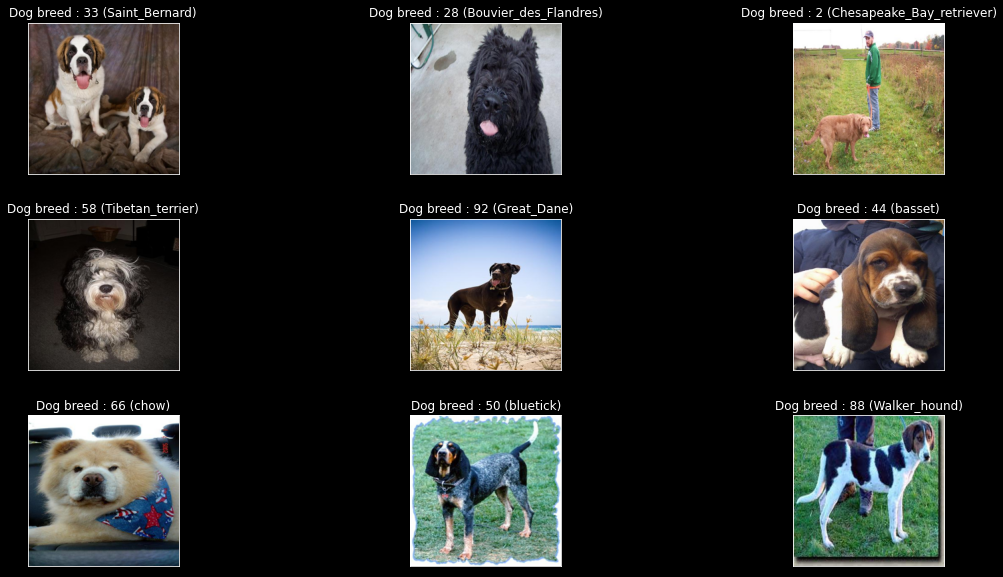

In [12]:
display_rand_images(images, labels, names)

In [13]:
# Shuffle the data
n = np.arange(images.shape[0])
np.random.seed(42)
np.random.shuffle(n)
images = images[n]
labels = labels[n]

In [14]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(images, labels, test_size=0.2, random_state=42) # THIS IS THE DATA TO PROCESS

### Data for Explore

In [15]:
# put flattened images and labels in a dataframe
df = pd.DataFrame(images.reshape(images.shape[0], -1))
df['labels'] = labels
df

,0,1,2,3,4,5,6,7,8,9,...,154578,154579,154580,154581,154582,154583,154584,154585,154586,labels
0,0.498039,0.380392,0.231373,0.525490,0.403922,0.250980,0.521569,0.407843,0.258824,0.533333,...,0.086275,0.101961,0.145098,0.094118,0.109804,0.152941,0.098039,0.113725,0.156863,94
1,0.513726,0.505882,0.317647,0.450980,0.450980,0.274510,0.431373,0.443137,0.286275,0.678431,...,0.454902,0.505882,0.490196,0.454902,0.505882,0.486275,0.454902,0.498039,0.482353,19
2,0.058824,0.054902,0.047059,0.058824,0.054902,0.047059,0.058824,0.054902,0.047059,0.058824,...,0.439216,0.325490,0.200000,0.439216,0.325490,0.200000,0.431373,0.321569,0.196078,116
3,0.835294,0.784314,0.611765,0.819608,0.772549,0.592157,0.764706,0.717647,0.533333,0.776471,...,0.117647,0.235294,0.196078,0.129412,0.247059,0.207843,0.133333,0.254902,0.215686,7
4,0.572549,0.584314,0.556863,0.431373,0.439216,0.415686,0.196078,0.207843,0.188235,0.203922,...,0.505882,0.513726,0.494118,0.509804,0.517647,0.498039,0.513726,0.521569,0.501961,114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20575,0.054902,0.082353,0.050980,0.062745,0.090196,0.058824,0.047059,0.078431,0.043137,0.050980,...,0.274510,0.286275,0.133333,0.215686,0.247059,0.082353,0.282353,0.313726,0.149020,66
20576,0.031373,0.011765,0.000000,0.043137,0.035294,0.023529,0.117647,0.117647,0.109804,0.129412,...,0.866667,0.894118,0.933333,0.854902,0.890196,0.925490,0.850980,0.886275,0.921569,70
20577,0.854902,0.603922,0.462745,0.847059,0.596078,0.454902,0.843137,0.592157,0.450980,0.831373,...,0.576471,0.513726,0.415686,0.509804,0.447059,0.349020,0.537255,0.474510,0.376471,32
20578,0.000000,0.003922,0.000000,0.054902,0.070588,0.019608,0.035294,0.047059,0.011765,0.007843,...,0.086275,0.074510,0.054902,0.082353,0.078431,0.062745,0.000000,0.000000,0.000000,4


In [16]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
# val_set, test_set = train_test_split(test_set, test_size=0.5, random_state=42)

# Explore the data


In [17]:
X_train, y_train = train_set.drop('labels', axis=1), train_set['labels']

In [18]:
train_subset = train_set.sample(n=1000, random_state=42)
X_train_subset, y_train_subset = train_subset.drop('labels', axis=1), train_subset['labels']

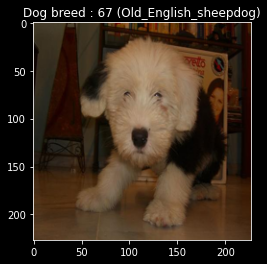

In [21]:
# plot the first row of the train set as an image
plt.imshow(X_train.iloc[0, :].values.reshape(227, 227, 3));
plt.title('Dog breed : {} ({})'.format(y_train.iloc[0], names[y_train.iloc[0]]));

In [ ]:
# This is about expected
# X_train_.describe()

In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16464 entries, 16375 to 15795
Columns: 154587 entries, 0 to 154586
dtypes: float32(154587)
memory usage: 9.5 GB


In [23]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,154577,154578,154579,154580,154581,154582,154583,154584,154585,154586
16375,0.262745,0.235294,0.164706,0.258824,0.231373,0.160784,0.254902,0.227451,0.156863,0.254902,...,0.109804,0.298039,0.196078,0.105882,0.298039,0.196078,0.105882,0.294118,0.192157,0.101961
16615,0.600000,0.658824,0.388235,0.647059,0.705882,0.435294,0.666667,0.725490,0.462745,0.611765,...,0.298039,0.282353,0.341176,0.188235,0.396078,0.454902,0.301961,0.227451,0.286275,0.133333
10098,0.666667,0.843137,0.874510,0.709804,0.870588,0.901961,0.745098,0.886275,0.913725,0.749020,...,0.909804,0.968627,0.941176,0.898039,0.964706,0.929412,0.886275,0.937255,0.894118,0.839216
7677,0.415686,0.376471,0.341176,0.529412,0.478431,0.443137,0.549020,0.486275,0.439216,0.494118,...,0.705882,0.831373,0.756863,0.705882,0.862745,0.803922,0.752941,0.847059,0.796078,0.729412
18717,0.321569,0.254902,0.278431,0.294118,0.227451,0.250980,0.298039,0.227451,0.250980,0.345098,...,0.239216,0.286275,0.435294,0.243137,0.266667,0.411765,0.235294,0.247059,0.392157,0.227451


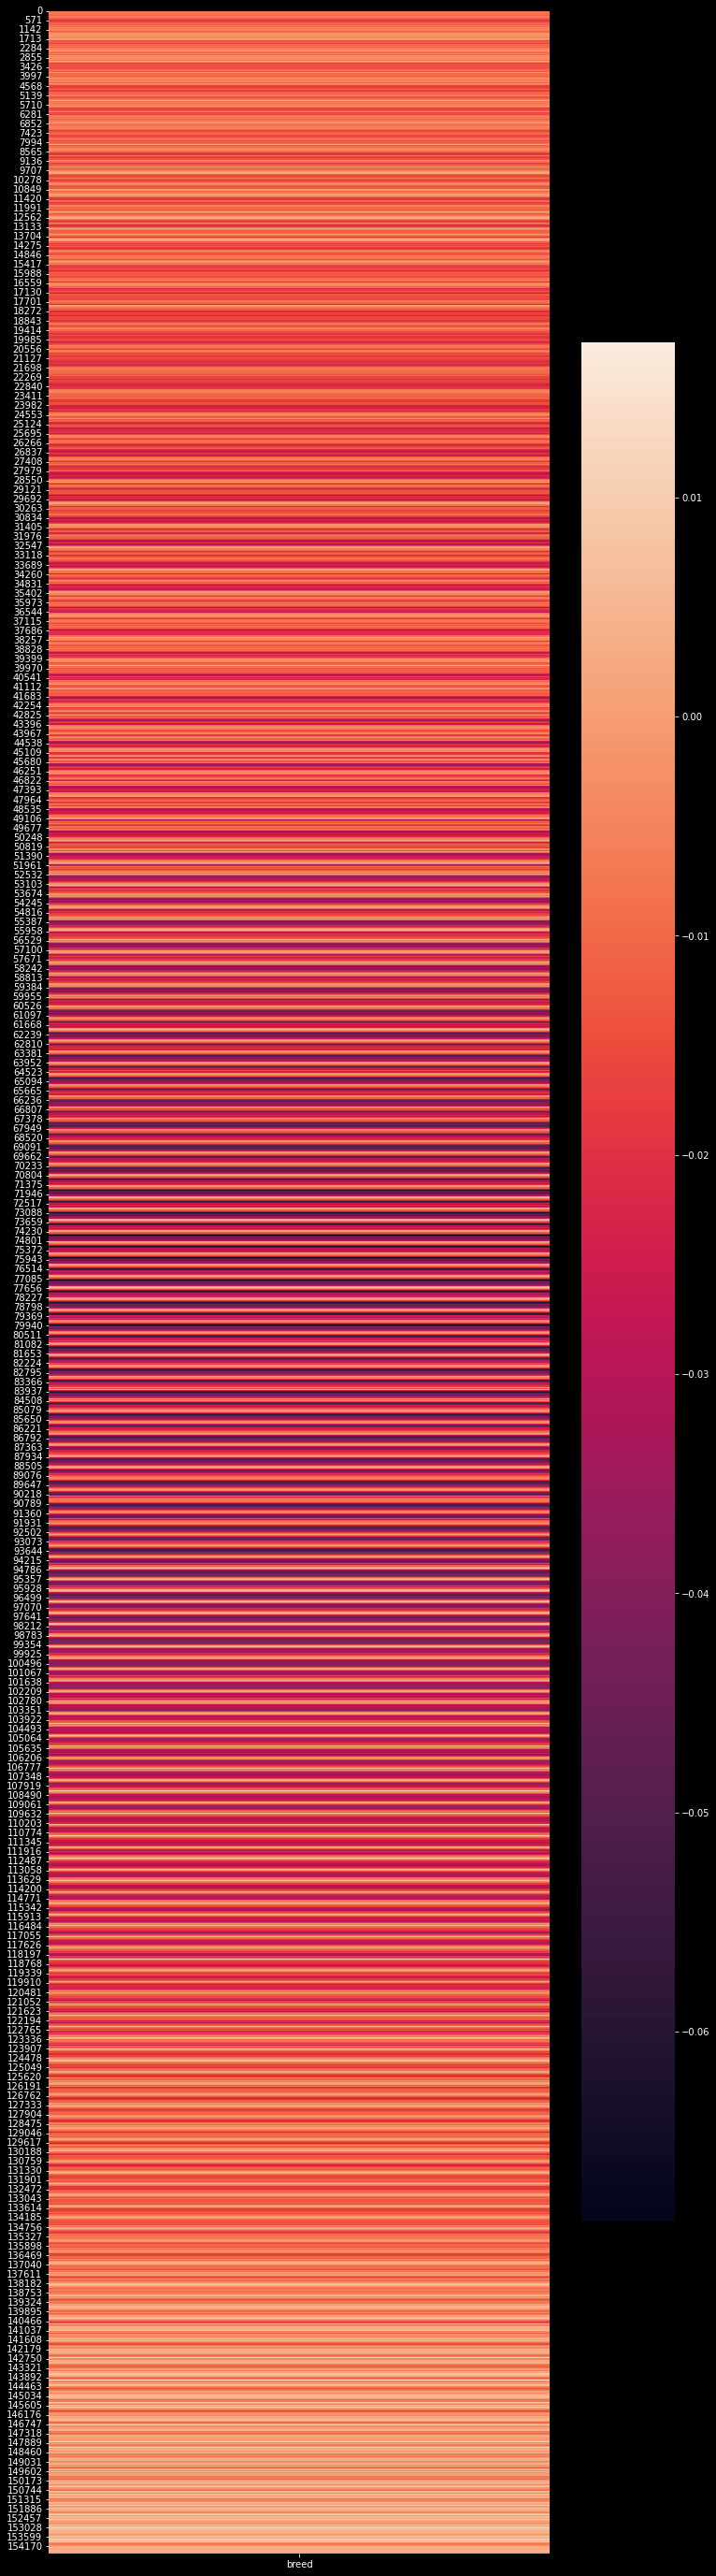

In [24]:
# Look for the useless features
c = pd.DataFrame({'breed': X_train.corrwith(y_train)})
plt.figure(figsize=(12,50))
sns.heatmap(c);

### Look at each color channel

In [25]:
# get each color channel
r = X_train[X_train.columns[0::3]]
g = X_train[X_train.columns[1::3]]
b = X_train[X_train.columns[2::3]]

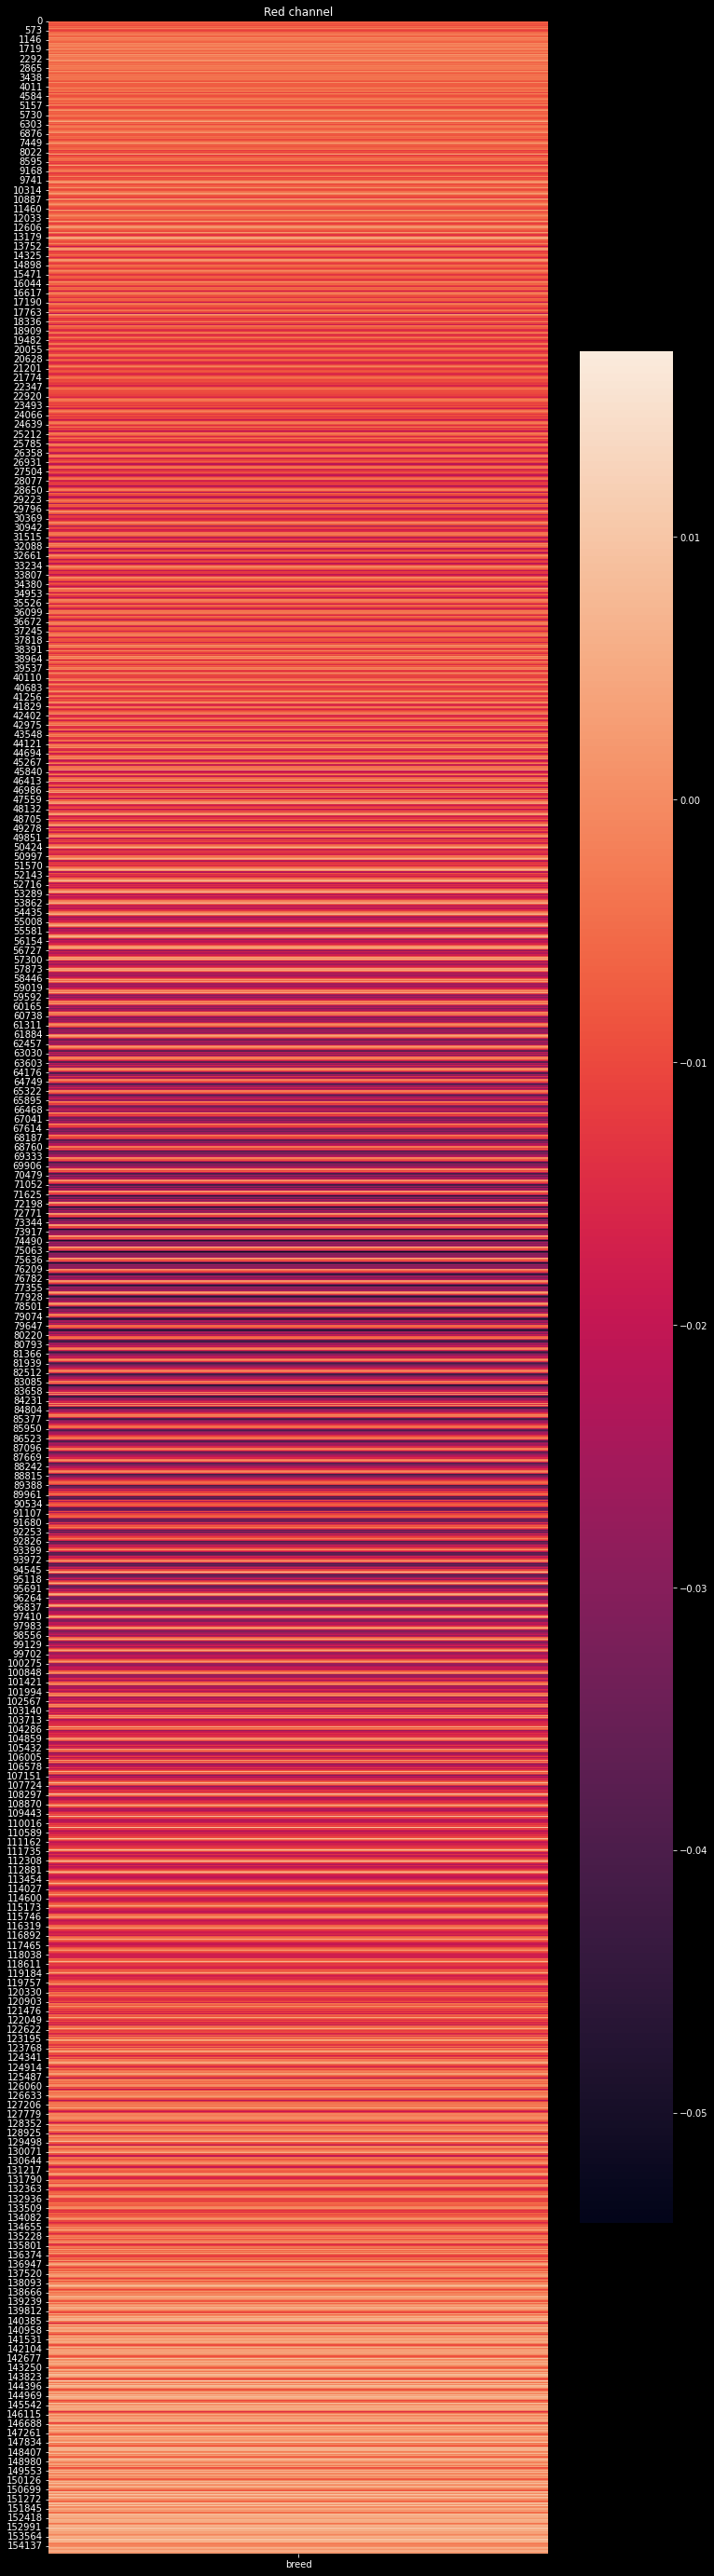

In [26]:
c = pd.DataFrame({'breed': r.corrwith(y_train)})
plt.figure(figsize=(12,50))
plt.title('Red channel')
sns.heatmap(c);

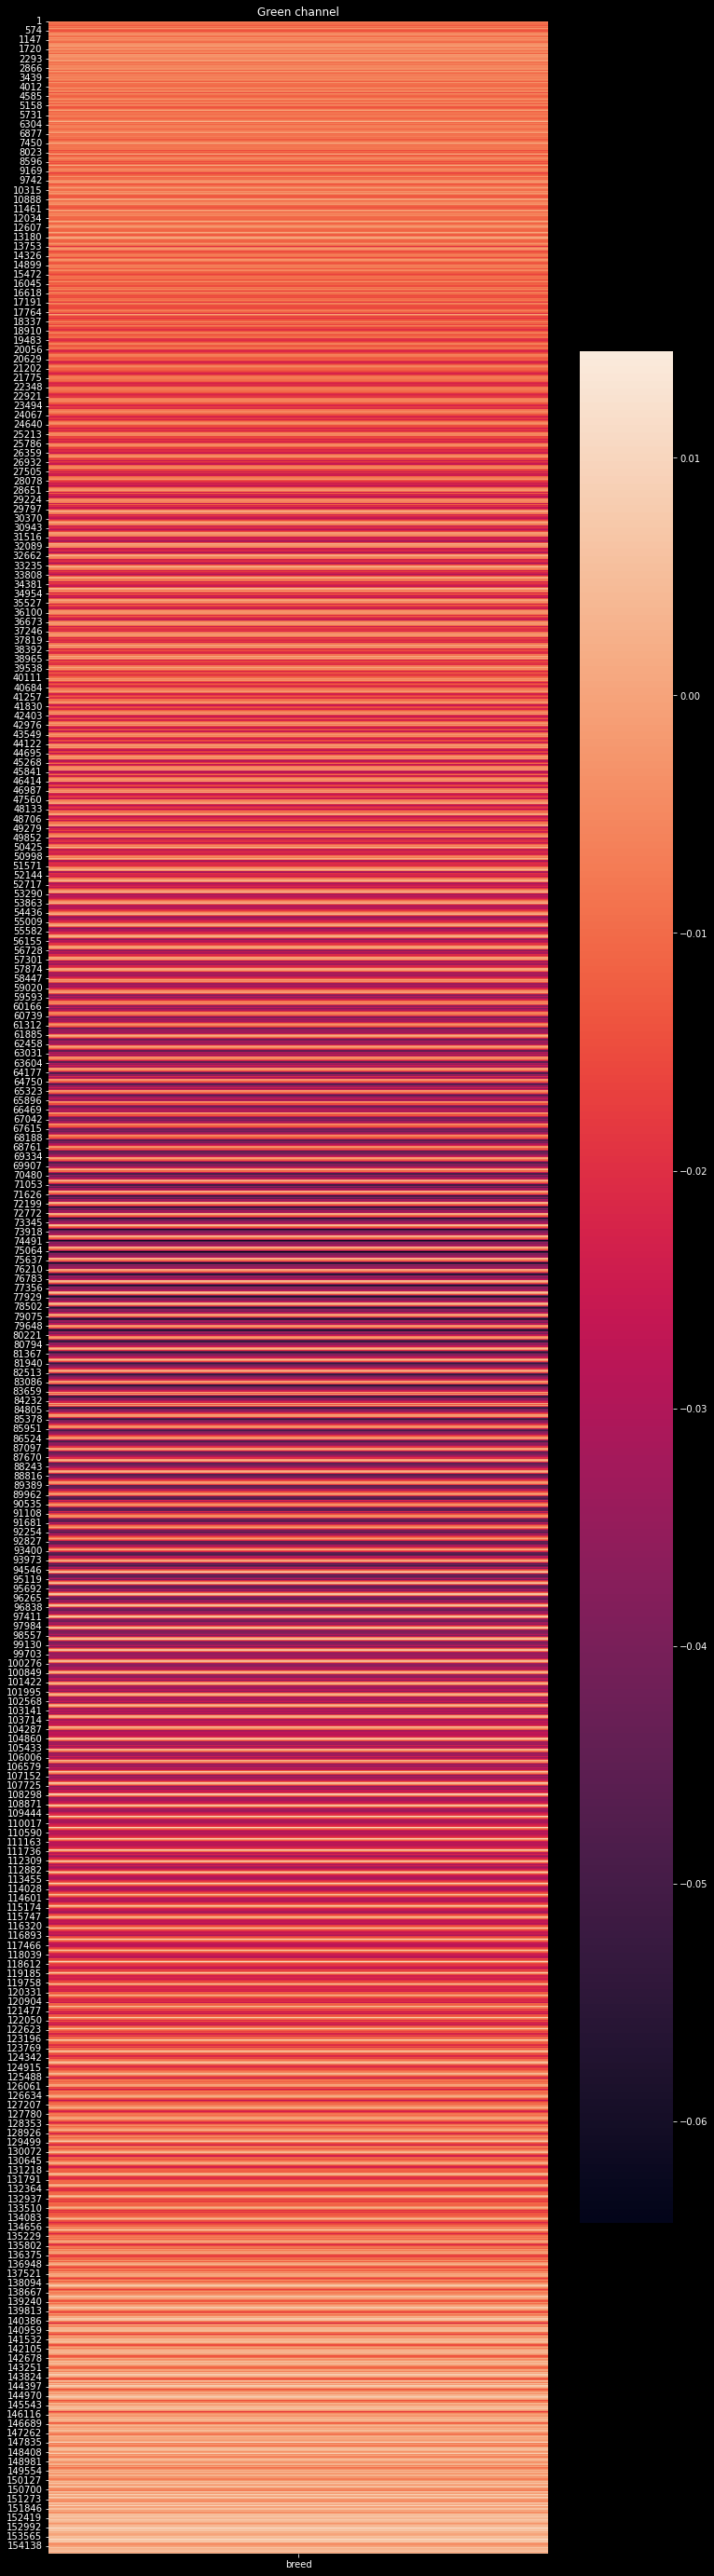

In [27]:
c = pd.DataFrame({'breed': g.corrwith(y_train)})
plt.figure(figsize=(12,50))
plt.title('Green channel')
sns.heatmap(c);

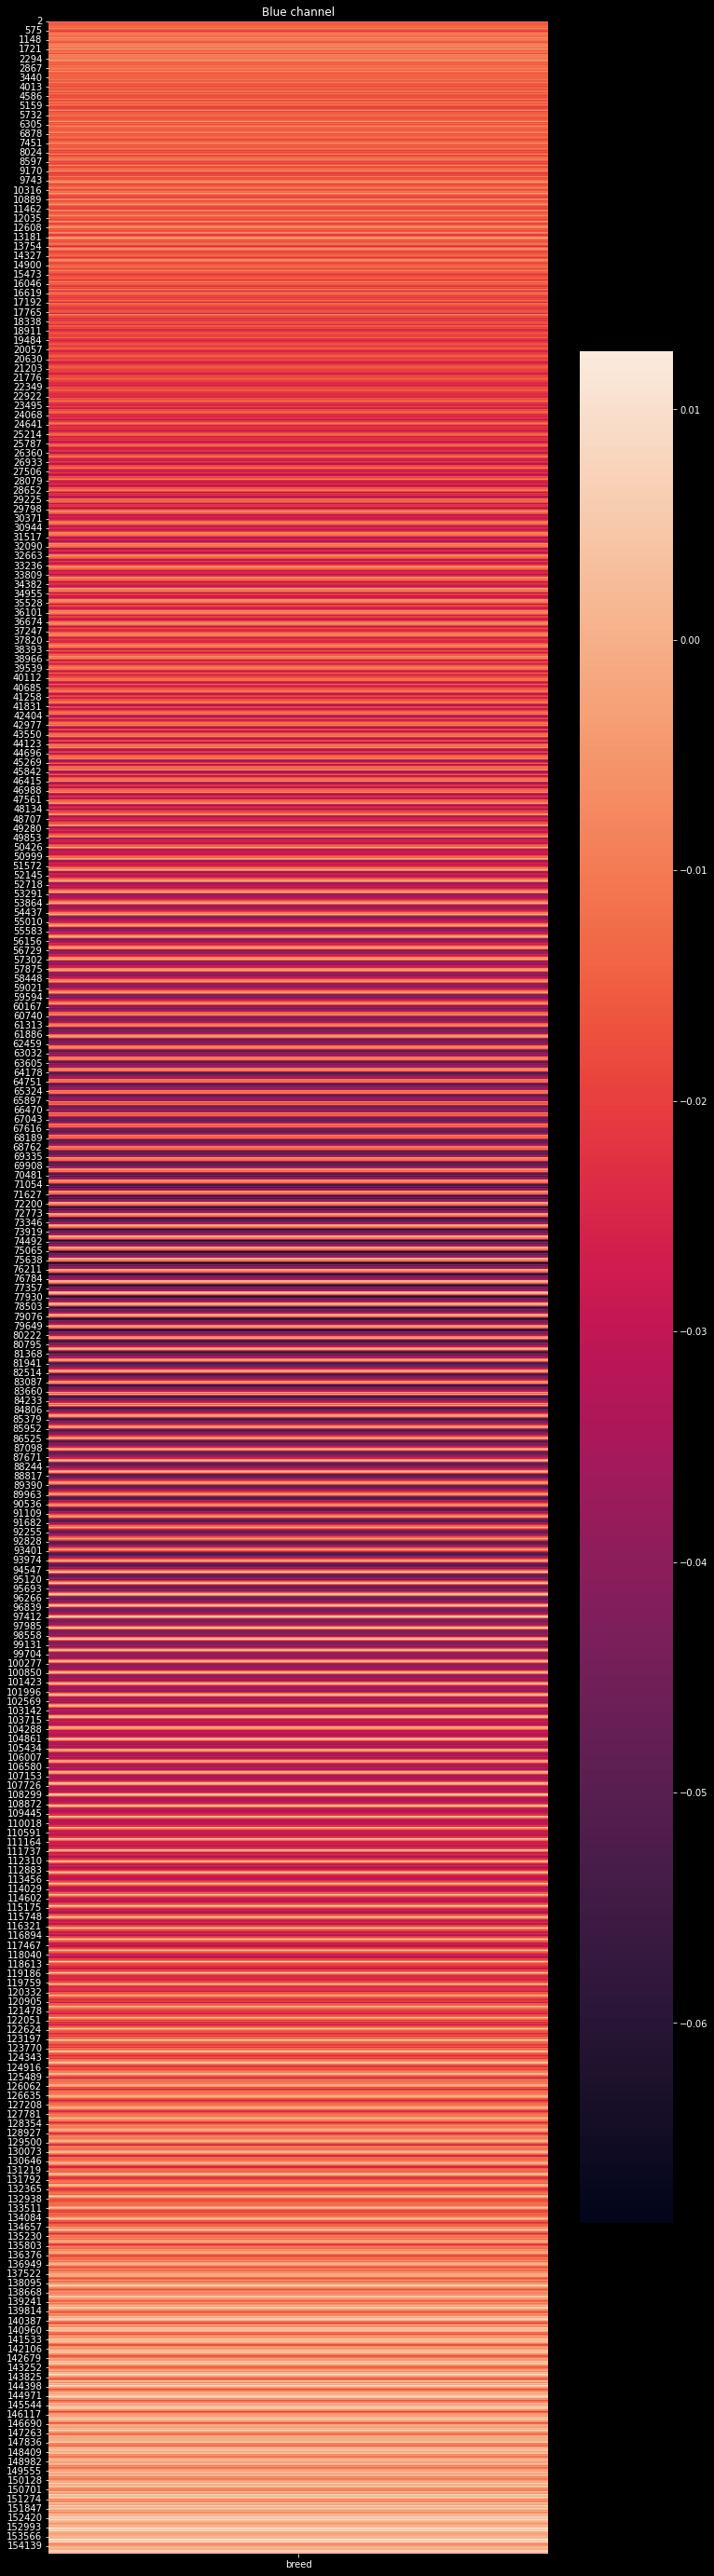

In [28]:
c = pd.DataFrame({'breed': b.corrwith(y_train)})
plt.figure(figsize=(12,50))
plt.title('Blue channel')
sns.heatmap(c);

## PCA

In [29]:
pca = PCA(n_components=0.99)
pca.fit(X_train, y_train)

plt.figure()
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Number of features')
plt.ylabel('Cumulative explained variance')

Error: Canceled future for execute_request message before replies were done

In [2]:
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

NameError: name 'pca' is not defined

In [1]:
# Let's see how good the recovery is
display_images(X_recovered.reshape(X_train.shape[0], 227, 227, 3));

NameError: name 'display_images' is not defined

In [17]:
# Find importances of each feature
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
sorted(zip(rf.feature_importances_, X_train.columns), reverse=True)

KeyboardInterrupt: 

## Try Grayscale

In [ ]:
# plot the first image
plt.imshow(cv2.cvtColor(X_train.iloc[0,:].values.reshape(227, 227, 3).astype('uint8'), cv2.COLOR_RGB2GRAY), cmap='gray');
plt.title('Dog breed : {} ({})'.format(y_train.iloc[0], names[y_train.iloc[0]]));

In [ ]:
ims = X_train.iloc[:,:].values.reshape(X_train.shape[0], 227, 227, 3).astype('uint8')

In [ ]:
X_subset_gray = np.array([cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) for im in ims])

In [ ]:
display_images(X_subset_gray, gray=True)

In [ ]:
X_subset_gray = pd.DataFrame(X_subset_gray.reshape(X_subset_gray.shape[0], -1))

In [ ]:
# Look at the useless features
c = pd.DataFrame({'breed': X_subset_gray.corrwith(y_train)})
plt.figure(figsize=(12,50))
sns.heatmap(c);

## Grayscale PCA

In [ ]:
pca_gray = PCA(n_components=0.99)
pca_gray.fit(X_subset_gray, y_train)

plt.figure()
plt.plot(pca_gray.explained_variance_ratio_.cumsum())
plt.xlabel('Number of features')
plt.ylabel('Cumulative explained variance')

In [ ]:
X_gray_reduced = pca_gray.fit_transform(X_subset_gray)
X_gray_recovered = pca_gray.inverse_transform(X_gray_reduced)

In [ ]:
# Let's see how good the recovery is
display_images(X_gray_recovered.reshape(X_train.shape[0], 227, 227)/255, gray=True);

In [ ]:
# Find importances of each feature
rf_gray = RandomForestClassifier()
rf_gray.fit(X_subset_gray, y_train)
sorted(zip(rf_gray.feature_importances_, X_subset_gray.columns), reverse=True)

# Prepare the data 

In [18]:
def rgb_to_gray(X, reshape=True):
    ims = X.values.reshape(X.shape[0], 227, 227, 3).astype('uint8')
    gray_ims = np.array([cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) for im in ims])
    if reshape:
        return pd.DataFrame(gray_ims.reshape(X.shape[0], -1))
    return pd.DataFrame(gray_ims.reshape(X.shape[0], -1).reshape(X.shape[0], 227, 227, 1))

In [19]:
preprocessor_gray = Pipeline([
    ('grayscale', FunctionTransformer(rgb_to_gray)),
    ('pca', PCA(n_components=0.99)), # TODO: Look at IncrementalPCA, may need for full dataset
])

In [20]:
preprocessor_color = Pipeline([
    ('pca', PCA(n_components=0.99)), # TODO: Look at IncrementalPCA, may need for full dataset
])

# Short-list

In [22]:
def build_dog_network(input_shape=X_train_[0].shape, n_hidden_layers=5, n_neurons=100):
    """
    """
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=input_shape, name='input'))
    for i in range(n_hidden_layers):
        model.add(keras.layers.Dense(n_neurons, activation="relu", name=f'hidden_{i}'))
    model.add(keras.layers.Dense(1, name='output'))
    model.summary()
    model.compile(optimizer="Nadam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [23]:
def build_alexnet():
    """
    """
    model=keras.models.Sequential()

    #1 conv layer
    model.add(keras.layers.Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(227,227,3)))

    #1 max pool layer
    model.add(keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)))

    model.add(keras.layers.BatchNormalization())

    #2 conv layer
    model.add(keras.layers.Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

    #2 max pool layer
    model.add(keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)))

    model.add(keras.layers.BatchNormalization())

    #3 conv layer
    model.add(keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

    #4 conv layer
    model.add(keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

    #5 conv layer
    model.add(keras.layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

    #3 max pool layer
    model.add(keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)))

    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Flatten())

    #1 dense layer
    model.add(keras.layers.Dense(4096,input_shape=(227,227,3),activation="relu"))

    model.add(keras.layers.Dropout(0.4))

    model.add(keras.layers.BatchNormalization())

    #2 dense layer
    model.add(keras.layers.Dense(4096,activation="relu"))

    model.add(keras.layers.Dropout(0.4))

    model.add(keras.layers.BatchNormalization())

    #3 dense layer
    model.add(keras.layers.Dense(1000,activation="relu"))

    model.add(keras.layers.Dropout(0.4))

    model.add(keras.layers.BatchNormalization())

    #output layer
    model.add(keras.layers.Dense(20,activation="softmax"))

    model.summary()

    return model

## Gray-scale

### Random Forest

In [ ]:
rf_gray_pipeline = Pipeline([
    ('preprocessor', preprocessor_gray),
    ('classifier', RandomForestClassifier())
]).fit(X_train_, y_train_)

In [ ]:
rf_gray_scores = cross_val_score(rf_gray_pipeline, X_train_, y_train_, scoring="accuracy")
rf_gray_scores

In [ ]:
for name, importance in sorted(zip(X_train_.columns, rf_gray_pipeline.named_steps.classifier.feature_importances_), key=lambda x: x[1], reverse=True):
    print(name, importance)

### Extra Trees

In [ ]:
et_gray_pipeline = Pipeline([
        ('preprocessor', preprocessor_gray),
        ('classifier', ExtraTreesClassifier())
]).fit(X_train_, y_train_)

In [ ]:
et_gray_scores = cross_val_score(et_gray_pipeline, X_train_, y_train_, scoring="accuracy")
et_gray_scores

In [ ]:
for name, importance in sorted(zip(X_train_.columns, et_gray_pipeline.named_steps.classifier.feature_importances_), key=lambda x: x[1], reverse=True):
    print(name, importance)

### Gray Neural Nets

#### Our Own Neural Net

In [ ]:
nn_grey_clf = keras.wrappers.scikit_learn.KerasClassifier(build_dog_network, input_shape=X_train_.shape[1]//3, n_hidden_layers=5, n_neurons=100)

In [ ]:
nn_grey = Pipeline([
    ('grayscale', FunctionTransformer(rgb_to_gray)),
    ('classifier', nn_grey_clf),
]).fit(X_train_, y_train_)

In [ ]:
nn_cust_grey_scores = cross_val_score(nn_grey, X_train_, y_train_, scoring="accuracy")
nn_cust_grey_scores

#### AlexNet for Grey Scale

In [ ]:
alexnet_grey = build_alexnet()

In [ ]:
alexnet_grey.fit(rgb_to_gray(X_train_).astype(float), y_train_subset, epochs=10, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], validation_data=(X_val, y_val))

## Color

### Random Forest

In [25]:
rf_color_pipeline = Pipeline([
    ('classifier', RandomForestClassifier())
]).fit(X_train_, y_train_)

In [26]:
rf_color_scores = cross_val_score(rf_color_pipeline, X_train_, y_train_, scoring="accuracy")
rf_color_scores

/refactored-robot/lib64/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
for name, importance in sorted(zip(X_train_.columns, rf_color_pipeline.named_steps.classifier.feature_importances_), key=lambda x: x[1], reverse=True):
    print(name, importance)

### Extra Trees

In [ ]:
et_color_pipeline = Pipeline([
        ('classifier', ExtraTreesClassifier())
]).fit(X_train_, y_train_)

In [ ]:
et_color_scores = cross_val_score(et_color_pipeline, X_train_, y_train_, scoring="accuracy")
et_color_scores

In [ ]:
for name, importance in sorted(zip(X_train_.columns, et_color_pipeline.named_steps.classifier.feature_importances_), key=lambda x: x[1], reverse=True):
    print(name, importance)

### Color Neural Nets

#### Our Own Neural Net

In [ ]:
color_nn = keras.wrappers.scikit_learn.KerasClassifier(build_dog_network, input_shape=X_train_.shape[1], n_hidden_layers=5, n_neurons=100)

In [ ]:
color_nn.fit(X_train_, y_train_, epochs=10)

In [ ]:
nn_cust_color_scores = cross_val_score(color_nn, X_train_, y_train_, scoring="accuracy")
nn_cust_color_scores

#### AlexNet for colored

In [ ]:
alexnet_color = build_alexnet()

In [ ]:
alexnet_color.fit(X_train_, y_train_, epochs=10, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

# Fine-tune your models

# Present your solution 